# Our learning algorithm

### Introduction

In the last lesson, we saw how we could reach our "best fit line" -- that is, we saw how to find the linear regression model that most closely matched our data.  The way we could do this is by noticing that each linear regression model takes the form $\hat{y} = mx + b$, and by incrementally changing our $m$ (or $b$) parameter and plotting our the related RSS, we get a parabola. 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



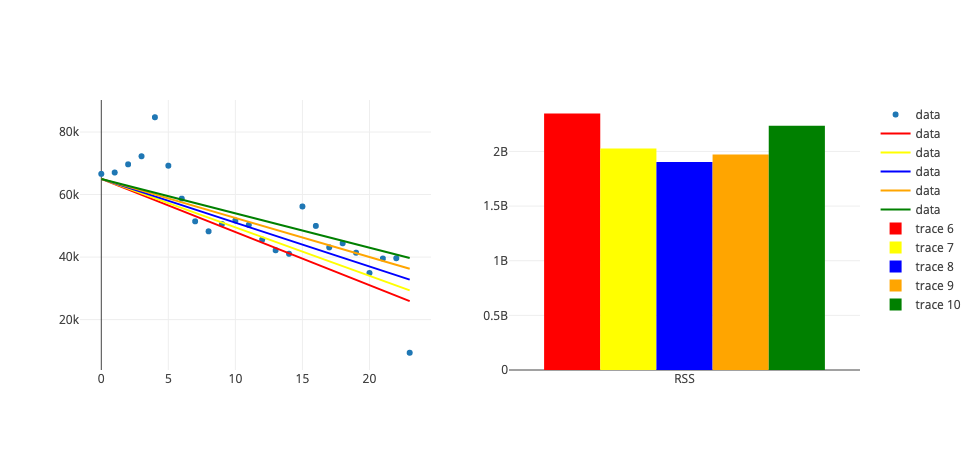

In [4]:
from graph import model_trace, trace_rss, pair_colors, plot_side_by_side
from graph import trace_values
b= 65000

import json
with open('months-since-revenues.json', 'r') as revenue_file:
    monthly_revenues = json.load(revenue_file)

month_numbers = list(map(lambda monthly_revenue: monthly_revenue['month_number'], monthly_revenues))
revenues = list(map(lambda monthly_revenue: monthly_revenue['revenue'], monthly_revenues))


m_values = list(range(-1700, -1000, 150))
rss_traces = []
model_traces = []

actual_trace = trace_values(x_values = month_numbers, y_values = revenues)

for m in m_values:
    rss_trace = trace_rss(m, b, month_numbers, revenues)
    rss_traces.append(rss_trace)
    built_model_trace = model_trace(m, b, month_numbers, revenues)
    model_traces.append(built_model_trace)
    
pair_colors(model_traces, rss_traces)
plot_side_by_side([actual_trace] + model_traces, rss_traces)

We wanted to choose the parameters that minimized our RSS as our RSS reflects closely the related regression model matches our data, and we wish to get as close as possible. 

Then we saw how we can use a Python to find this minimum value, and thus find the $m$ and $b$ parameters of our best fit line.  For example, below it finds we can minimize our RSS with a value of $-1378$.

In [5]:
from scipy import optimize
from error import rss
def rss_value_vary_m(m):
    b= 65000
    return rss(m, b, month_numbers, revenues)

optimize.minimize(rss_value_vary_m, x0=-1700)

      fun: 1900450395.2278943
 hess_inv: array([[3.59616137e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 5
     njev: 15
   status: 0
  success: True
        x: array([-1378.59792938])

In this lesson, we'll dive a little bit deeper into how computers find this minimum value.  Understanding this procedure is pretty critical to understanding many different machine learning algorithms.  If all machine learning algorithms involve a machine learning model, and a cost function, then each of them also wish to find the minimum of the cost function.  A popular mechanism for doing so is the procedure we'll see below.  And when we understand this procedure we can better understand how to watch out for problems with the procedure, and optimize it in the future.  

### Finding the minimum

The curve is constructed just like our multicolor plot above.  We're simply plotting how our RSS changes as we vary our values of $m$. 

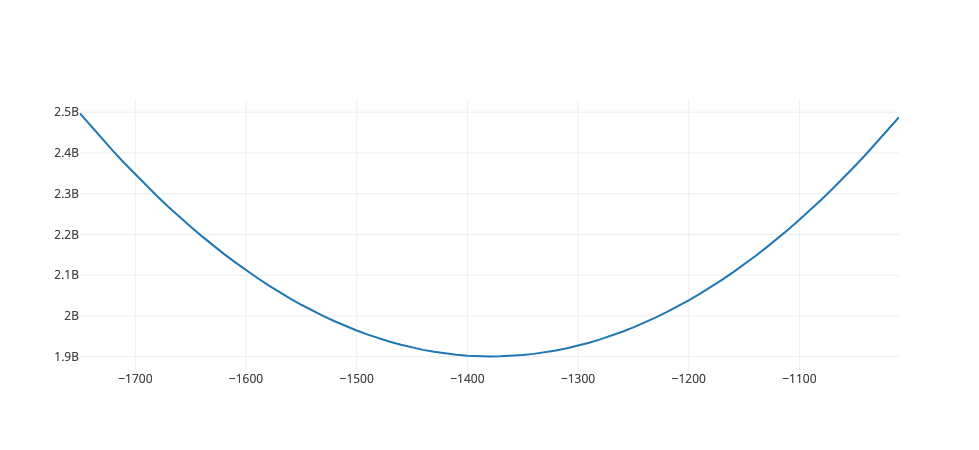

In [10]:
from graph import plot
b = 65000
m_values = list(range(-1750, -1000, 10))
rss_values = list(map(lambda m: rss(m, b, month_numbers, revenues), m_values))
rss_trace = trace_values(m_values, rss_values, mode = 'lines')
plot([rss_trace])

Now as we saw Python can find the minimum of this plot.  

```python
optimize.minimize(rss_value_vary_m, x0=-1700)
```

And it can do so without trying out every value.  

**Let's see the procedure and then we'll understand why it works** 

First we start at the point that we pass through as the $x0$ argument.  Above, we passed through the value -1700.  Then we calculates the slope of the RSS plot at this point.  So with the orange line below, you can see the slope of the line when $m= -1700$.

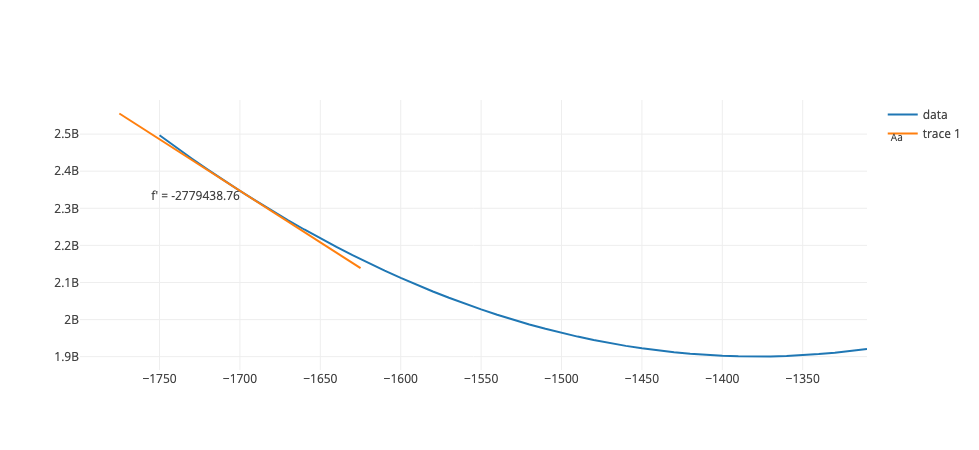

In [19]:
from calculus import derivative_trace
d_trace = derivative_trace(rss_value_vary_m, -1700, line_length = 150)
b = 65000
m_values = list(range(-1750, -1300, 10))
rss_values = list(map(lambda m: rss(m, b, month_numbers, revenues), m_values))
rss_trace = trace_values(m_values, rss_values, mode = 'lines')

plot([rss_trace, d_trace])

We take the slope of this at original value of $m$, and multiply the slope by a small negative number like $-.001$.  Whatever the result of this multiplying, we change the value of $m$ by that amount.

* $m = −1700 $
* $slope = -2779438 $

So then $-.0001*-2779438 = 278 $

So then we update our value of $m$ by this amount.

$new m = -1700 + 278 = -1422 $

Now we do this whole procedure a again.  We find the slope of our line at this new value of $m = -1422 $, find the slope of our RSS curve at that point, multiply that slope by $-.0001$ and update our $m$ value another time.

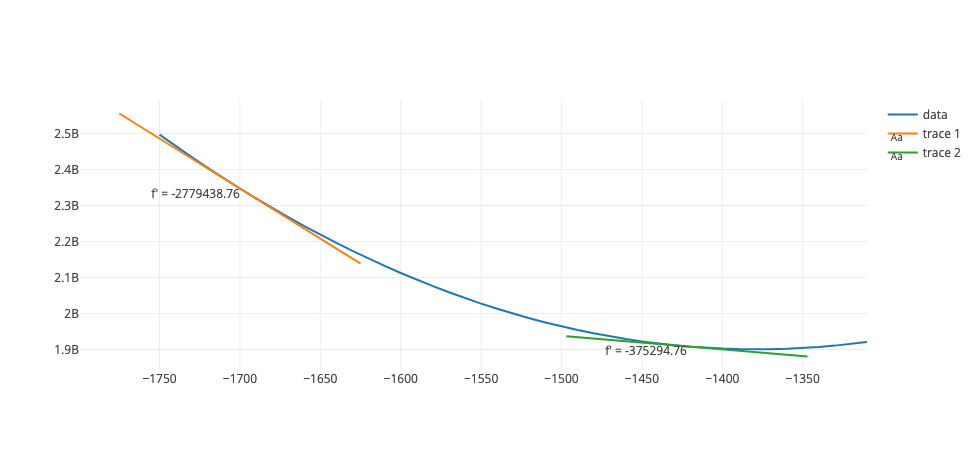

In [22]:
from calculus import derivative_trace
d_trace = derivative_trace(rss_value_vary_m, -1700, line_length = 150)
d_trace_two = derivative_trace(rss_value_vary_m, -1422, line_length = 150)
b = 65000
m_values = list(range(-1750, -1300, 10))
rss_values = list(map(lambda m: rss(m, b, month_numbers, revenues), m_values))
rss_trace = trace_values(m_values, rss_values, mode = 'lines')

plot([rss_trace, d_trace, d_trace_two])

Let's do this just one more time, and then we'll explain it.

* $m = −1422 $
* $slope = -375294 $

So then $-.0001*-375294 = 37.5 $

Again we update our value of $m$ by this number to get our new value.

$-1422 + 37.5 = -1385 $

Let's update our graph by placing the green line where our new value of $m$ is located.

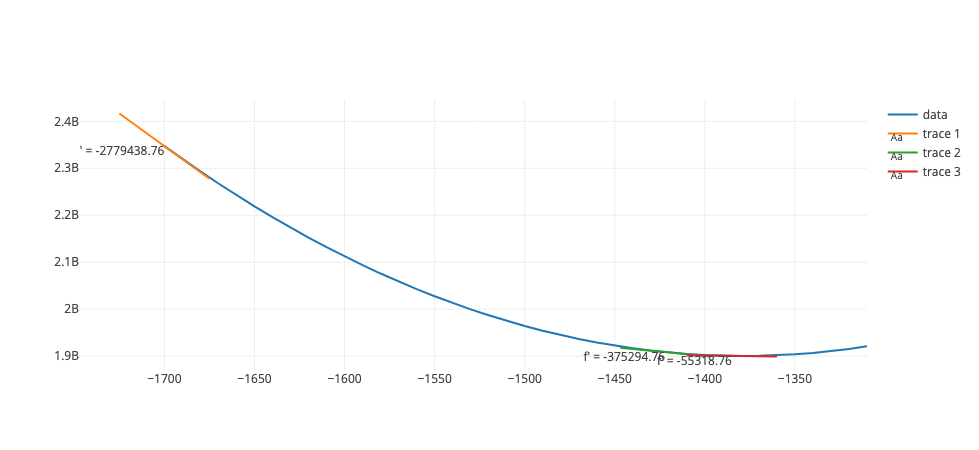

In [28]:
from calculus import derivative_trace
d_trace = derivative_trace(rss_value_vary_m, -1700, line_length = 50)
d_trace_two = derivative_trace(rss_value_vary_m, -1422, line_length = 50)
d_trace_three = derivative_trace(rss_value_vary_m, -1385, line_length = 50)
b = 65000
m_values = list(range(-1700, -1300, 10))
rss_values = list(map(lambda m: rss(m, b, month_numbers, revenues), m_values))
rss_trace = trace_values(m_values, rss_values, mode = 'lines')

plot([rss_trace, d_trace, d_trace_two, d_trace_three])

So notice that our red line is now quite close to our minimum.  Using this procedure we get to a value of -1385 in just a few steps, and when we asked Python to find the minimum it found a value of $-1378$.  So we got very close quite quickly.

### Why this procedure works so well

So our procedure of finding the minimum above was the following: 
* Start at some initial value of $m$. 
* Find the slope of the RSS curve at this point.
* Calculate an update value by multiplying the slope of RSS by a small negative number, -.001
* Update our new m to be the old m plus the update value calculated above.

Now let's understand why this works.  This works because with this procedure, we update our value of $m$, based on the slope of our parabola at this point, and **the further away from the minimum we are, the steeper the slope**, so the further away from the minimum of the curve, the more we will update our value of m.  Also, the closer we are to the minimum, the flatter the slope, and so we will update our value of m just a little.

We stop when we update our parameter by such a small number that we feel comfortable stopping, or after a set number of updates.

### Formalizing our procedure

Let's write some code that reflects the procedure in our bullet points above.  

> To find the slope at a point, we'll provide a function calculates the slope of a function at a give point, called `derivative_of`.  We won't go into the details of how we find the derivative of a function right now, so just take it as given that we can find the slope of a function at a given point, and doing so is called taking the derivative at that value.

In [48]:
from calculus import derivative_of

# set an initial value of m
m = -1700
# calculate the slope at that value of m 
slope_at_m = derivative_of(rss_value_vary_m, m, .01)

m = m + -.0001*slope_at_m

The last line is the most important.  It shows formula for how we improve our value of $m$, or as a machine learning engineer would say, this is how we *learn* $m$.

Let's rewrite this formula mathematically.

$m = m + -.0001*slopeofrss_m$

So this is our learning algorithm written mathematically.  Start with a value of m (to the right of the equals sign), then add the product of a small negative number times our slope, and set that result equal to the new value of m.

Ok, time for one more update.  This small negative number (-.0001) is called the learning rate.  It's called the learning rate because if we increase it our updates to our parameter will be larger, and vice versa.  Mathematicians use the symbol $\alpha$ for the learning rate, so let's replace it accordingly.

$m = m + -\alpha*slopeofrss_m$

### Multiple updates in code

Ok, now let's just prove this is real by doing multiple updates.  Our code is the same as previously, we just place it in a loop, and append our new value of $m$ each time.

In [49]:
number_of_iterations = 5
m_values = []
for iteration in list(range(0, number_of_iterations)):
    slope_at_m = derivative_of(rss_value_vary_m, m, .01)
    m = m + -.0001*slope_at_m
    m_values.append(m)


In [50]:
m_values

[-1384.478112,
 -1379.3975647,
 -1378.7106747,
 -1378.6178072,
 -1378.6052515000001]

Doing so shows how in just a few attempts we get zoom in on the value of -1378, which is the value of m that minimizes our RSS.  

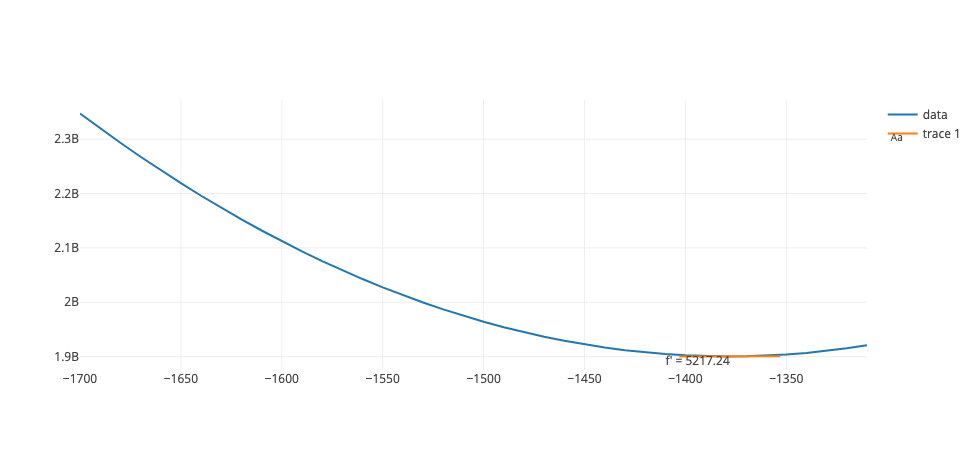

In [52]:
final_d_trace = derivative_trace(rss_value_vary_m, -1378, line_length = 50)
m_values = list(range(-1700, -1300, 10))
rss_values = list(map(lambda m: rss(m, b, month_numbers, revenues), m_values))
rss_trace = trace_values(m_values, rss_values, mode = 'lines')

plot([rss_trace, final_d_trace])

### Summary

In this lesson we dove deeper into how an algorithtm updates it's model.  In other words we dove deeper into how an algorithm learns.  We saw a stepwise procedure in which the algorithm looks at the slope of the RSS curve for a given value of m, and then updates that value of m by a the negative of a small number times that slope.  This means that our updates will be proportional to the size of the slope at a given value of m.  And because the further away from the minimum, the steeper the slope, this increases the size of the update.  As our algorithm approaches the value of m that produces the minimum, the slope of the RSS decreases, and thus so do the updates.  When those updates are sufficiently small, we stop our algorithm and use the corresponding value of m for our model.

We translated this algorithm into code and expressed this mathematically as:

$m = m + -.0001*slopeofrss_m$

We call this small number .0001 our learning rate, $\alpha$ as influences the size of the updates of our parameters, so we can rewrite our formula as the following:

$m = m + -\alpha*slopeofrss_m$